In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("/content/drive/My Drive/DataSet/mediacompany.csv")
df.drop("Unnamed: 7",axis=1,inplace=True)
df.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A
0,3/1/2017,183738,1260228,1706478,1060860448,0,0
1,3/2/2017,193763,1270561,1690727,1031846645,0,0
2,3/3/2017,210479,1248183,1726157,1010867575,0,0
3,3/4/2017,240061,1492913,1855353,1079194579,1,0
4,3/5/2017,446314,1594712,2041418,1357736987,0,0


So, what we are trying to predict is that the "Views_show" given x predictors


####Date --> Date of the show
####Visitors --> Total Visitors who watched the Show
####Views_Platform --> Total Visitors using x platforms
####Ad_impression --> Totalads popup & clicked 
####Circket_match --> Is there a cricket match.apply(lambda x : 1 if yes else 0)
####Character_A --> Is theres a big actors / fav actors for most people 


In [0]:
from datetime import date
df["Date"]=pd.to_datetime(df["Date"])
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
dateBeforeShow = date(2017 , 2 ,28)
dateBeforeShow = pd.to_datetime(dateBeforeShow)
df["TotalDayPlayed"] = df["Date"] - dateBeforeShow
df["TotalDayPlayed"] = df["TotalDayPlayed"].astype("str")
df["TotalDayPlayed"] = df["TotalDayPlayed"].apply(lambda rows : rows[0:2] )
df["TotalDayPlayed"] = df["TotalDayPlayed"].astype(int)
df["is_weekend"] = np.where(df["Date"].dt.dayofweek < 5 , 0 , 1)
df.sort_values(by=["Date"],axis=0)
df.drop("Date",axis=1,inplace=True)



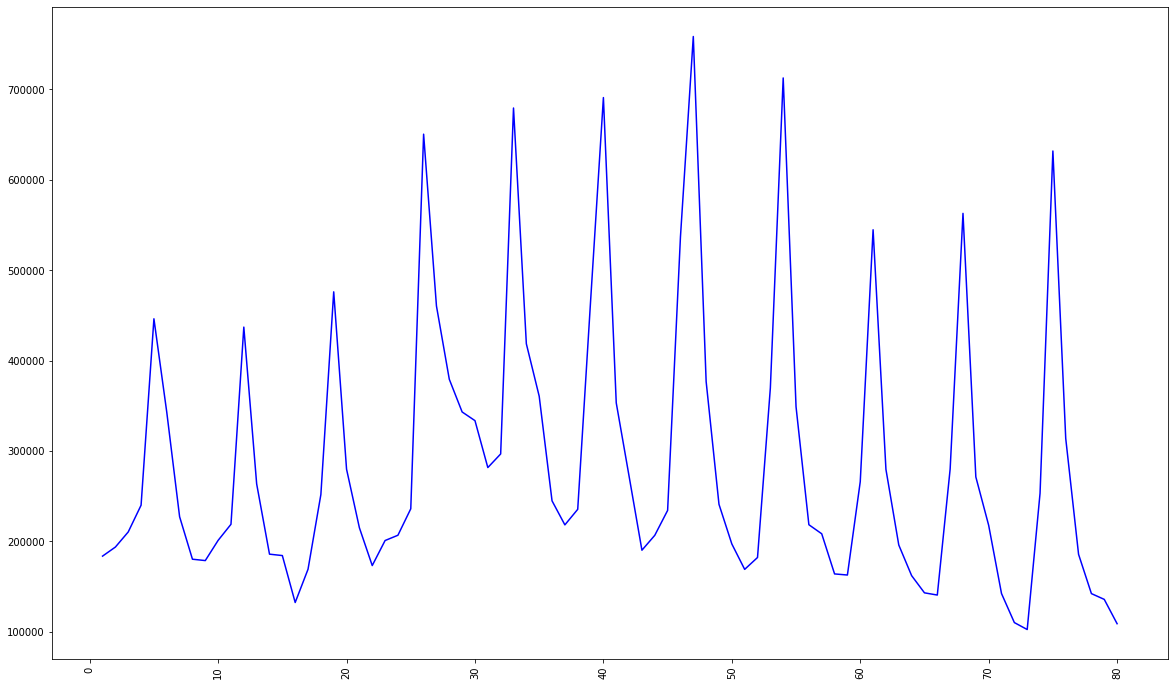

In [5]:
plt.figure(figsize=(20,12))
plt.plot(df[ "TotalDayPlayed" ],df["Views_show"] ,color='blue')
plt.xticks(rotation=90)
plt.show()

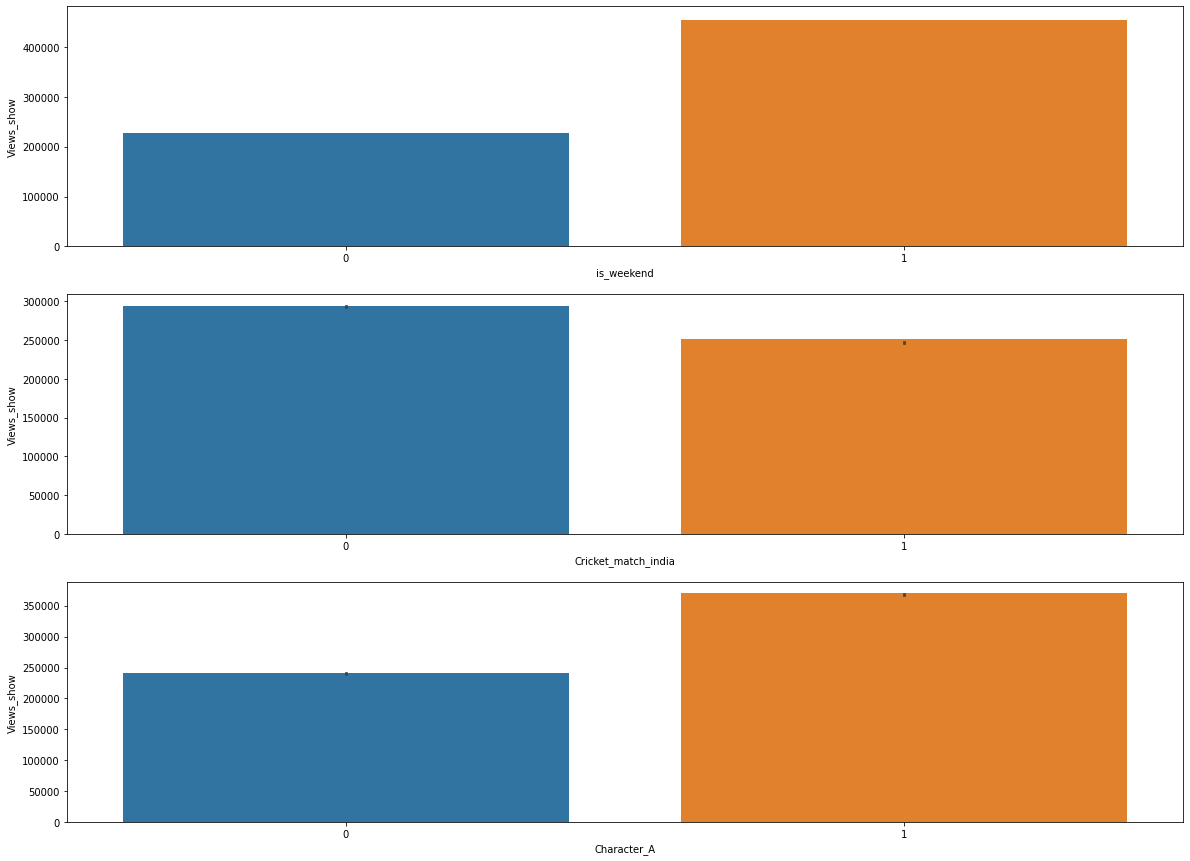

In [6]:
f,ax=plt.subplots(figsize=(20,15) , nrows = 3)
sns.barplot(df[ "is_weekend" ],df["Views_show"] ,ax=ax[0] ,ci=0.95 )
sns.barplot(df["Cricket_match_india"] , df["Views_show"],ax=ax[1] , ci=0.95)
sns.barplot(df["Character_A"],df["Views_show"],ax=ax[2],ci=0.95)
plt.show()

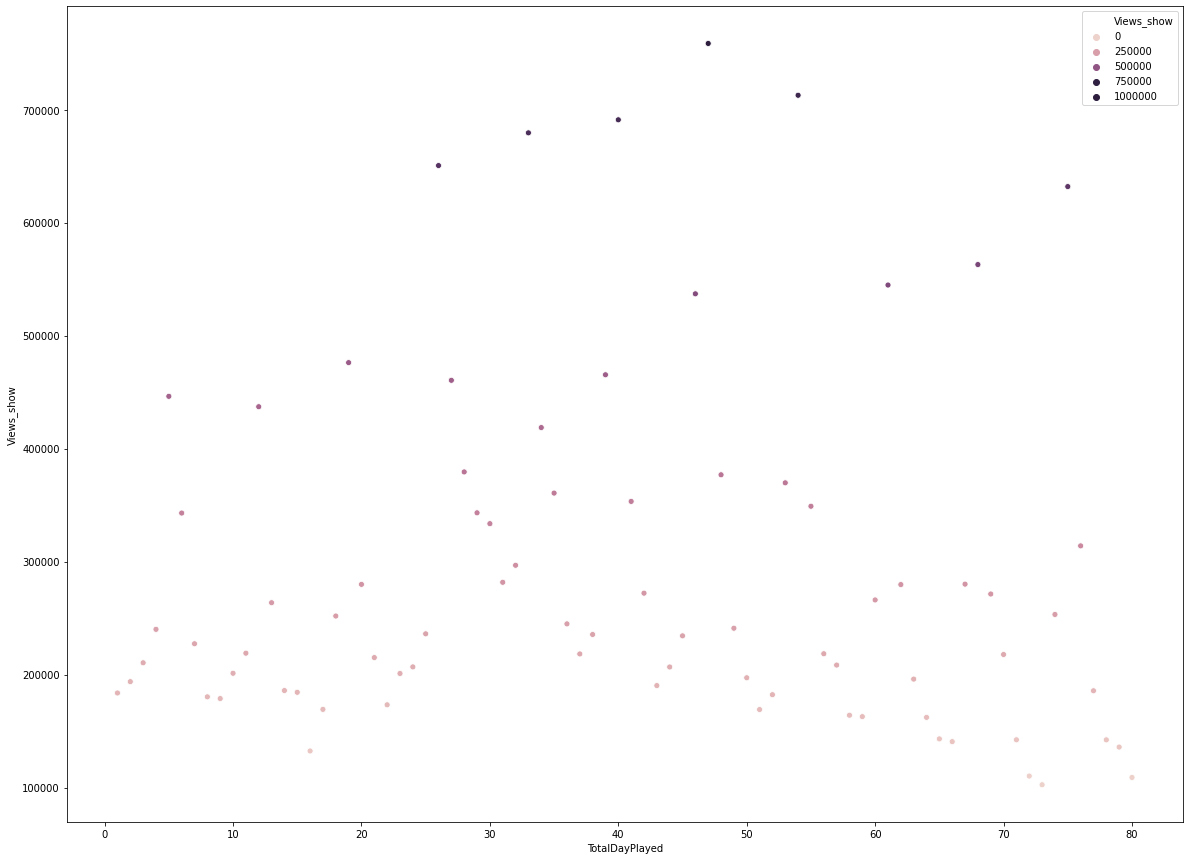

In [7]:
## Cuz this Data Only 80 datapoint so it's ez to measure the views_show given day
plt.figure(figsize=(20,15))
sns.scatterplot(x = "TotalDayPlayed" , y = "Views_show" ,data=df , hue = "Views_show")
plt.show()



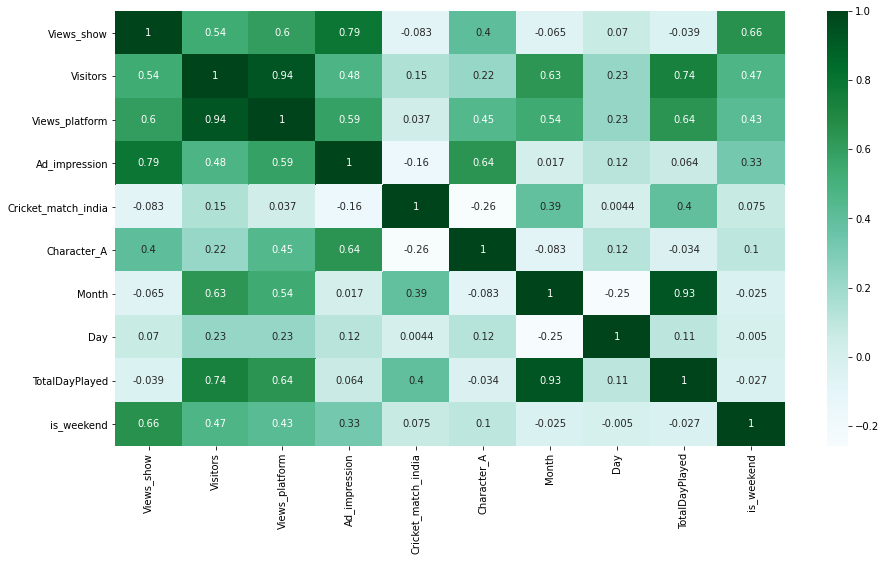

In [8]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr() , cmap ="BuGn" , annot=True)

In [9]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
df[["Ad_impression","Views_platform"]] = sc.fit_transform(df[["Ad_impression" , 'Views_platform']] )
df.head()

,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,Month,Day,TotalDayPlayed,is_weekend
0,183738,1260228,-1.781967,-1.286948,0,0,3,1,1,0
1,193763,1270561,-1.836370,-1.384819,0,0,3,2,2,0
2,210479,1248183,-1.713997,-1.455587,0,0,3,3,3,0
3,240061,1492913,-1.267762,-1.225102,1,0,3,4,4,1
4,446314,1594712,-0.625104,-0.285503,0,0,3,5,5,1


In [10]:
import statsmodels.api as sm
X = df[['is_weekend','Character_A','Ad_impression',"Views_platform","TotalDayPlayed","Cricket_match_india"]]
X=sm.add_constant(X)
target=df["Views_show"]
LinearRed=sm.OLS( target ,X ).fit()
print(LinearRed.summary())


                            OLS Regression Results                            
Dep. Variable:             Views_show   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     82.91
Date:                Wed, 27 May 2020   Prob (F-statistic):           1.42e-30
Time:                        08:12:06   Log-Likelihood:                -986.83
No. Observations:                  80   AIC:                             1988.
Df Residuals:                      73   BIC:                             2004.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.431e+05   3

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
Predicted_views = LinearRed.predict(X)
mse = mean_squared_error(df.Views_show, Predicted_views)
r_squared = r2_score(df.Views_show, Predicted_views)
print('Mean_Squared_Error :' ,mse)
print("RootMeanSquaredError : ",round(np.sqrt(mse)),5)
print('r_square_value :',r_squared)

Mean_Squared_Error : 3033114006.401306
RootMeanSquaredError :  55074.0 5
r_square_value : 0.8720287497445439


Text(0, 0.5, 'Views')

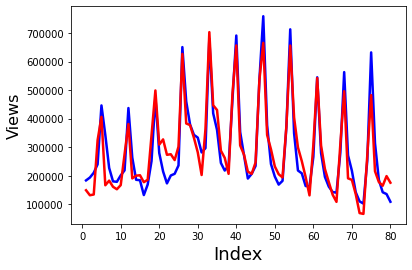

In [12]:
plt.plot(df["TotalDayPlayed"],df.Views_show, color="blue", linewidth=2.5, linestyle="-")
plt.plot(df["TotalDayPlayed"],Predicted_views, color="red",  linewidth=2.5, linestyle="-")
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Views', fontsize=16)                               # Y-label

Text(0.5, 1.0, 'Skew 0.5416697233007486 ')

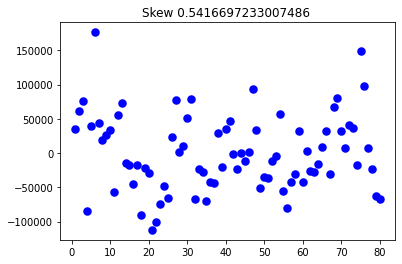

In [13]:
# We're going to plot the Error Tersms

# Error terms

plt.scatter(df["TotalDayPlayed"], df.Views_show - Predicted_views , color="blue", linewidth=2.5)
plt.title("Skew {} " . format((df["Views_show"] - Predicted_views).skew()  )) 

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
SVR_params = {"kernel" : ["rbf",'poly'],
              "degree" : np.arange(1,10,1) }

SVR_Model=GridSearchCV(estimator=SVR() , param_grid = SVR_params ,
                       verbose = True , cv =5,
                       n_jobs  = -1)
SVR_Model.fit(X , target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [15]:
Predicted_views =SVR_Model.predict(X)
mse = mean_squared_error(df.Views_show, Predicted_views)
r_squared = r2_score(df.Views_show, Predicted_views)
print('Mean_Squared_Error :' ,mse)
print("RootMeanSquaredError : ",round(np.sqrt(mse)),5)
print('r_square_value :',r_squared)

Mean_Squared_Error : 26680386918.54414
RootMeanSquaredError :  163341.0 5
r_square_value : -0.12568220781005035


Text(0, 0.5, 'Views')

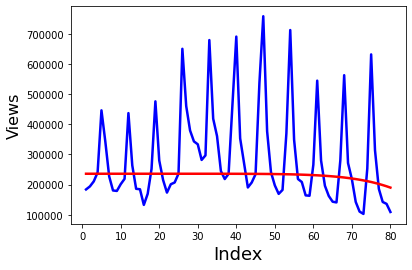

In [16]:
plt.plot(df["TotalDayPlayed"],df.Views_show, color="blue", linewidth=2.5, linestyle="-")
plt.plot(df["TotalDayPlayed"],Predicted_views, color="red",  linewidth=2.5, linestyle="-")
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Views', fontsize=16)                               # Y-label

Text(0, 0.5, 'ERror')

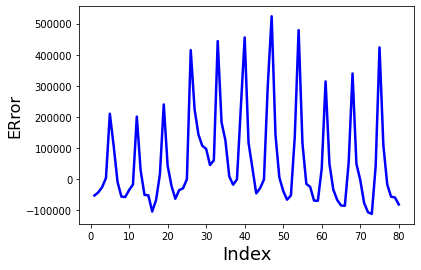

In [17]:
# We're going to plot the Error Tersms

# Error terms

plt.plot(df["TotalDayPlayed"], df.Views_show - Predicted_views , color="blue", linewidth=2.5)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel("ERror", fontsize=16)                # Y-label

In [18]:
Random_params= {
                "max_depth":[None,1,3,5,7],
                "min_samples_split" : np.arange(1,20,1),
                "min_samples_leaf" : np.arange(1,10,1)}

Model_Rf=GridSearchCV(estimator = RandomForestRegressor(),
                      param_grid = Random_params ,
                      verbose = True,n_jobs=-1)
Model_Rf.fit(X,target)

Fitting 5 folds for each of 855 candidates, totalling 4275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4275 out of 4275 | elapsed:  7.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [19]:
Predicted_views = Model_Rf.predict(X)
mse = mean_squared_error(df.Views_show, Predicted_views)
r_squared = r2_score(df.Views_show, Predicted_views)
print('Mean_Squared_Error :' ,mse)
print("RootMeanSquaredError : ",round(np.sqrt(mse)),5)
print('r_square_value :',r_squared)

Mean_Squared_Error : 655771469.1360973
RootMeanSquaredError :  25608.0 5
r_square_value : 0.9723321000759968


Text(0, 0.5, 'Views')

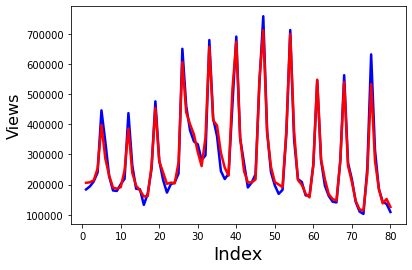

In [20]:
plt.plot(df["TotalDayPlayed"],df.Views_show, color="blue", linewidth=2.5, linestyle="-")
plt.plot(df["TotalDayPlayed"],Predicted_views, color="red",  linewidth=2.5, linestyle="-")
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Views', fontsize=16)                               # Y-label

Text(0, 0.5, 'ERror')

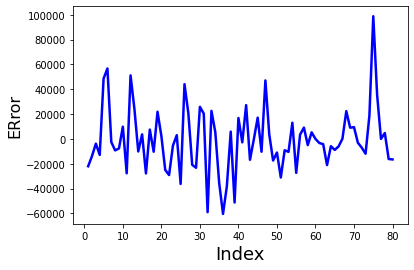

In [21]:
# We're going to plot the Error Tersms

# Error terms

plt.plot(df["TotalDayPlayed"], df.Views_show - Predicted_views , color="blue", linewidth=2.5)            
plt.xlabel('Index', fontsize=18)                   
plt.ylabel("ERror", fontsize=16)               